# 케라스 전이 학습(Transfer Learning)

<img src="https://miro.medium.com/max/5252/1*Z11P-CjNYWBofEbmGQrptA.png">

<sub>출처: https://medium.com/the-official-integrate-ai-blog/transfer-learning-explained-7d275c1e34e2</sub>


In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Activation
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *

In [22]:
vgg16 = VGG16(weights='imagenet', input_shape=(32, 32, 3), include_top=False)

In [23]:
model = Sequential()
model.add(vgg16)

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense (10, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_5 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 10)                2570      
                                                      

In [24]:
mobilenet = MobileNet(weights=None, input_shape=None, include_top=True)
resnet50 = ResNet50(weights=None, input_shape=None, include_top=True)
xception = Xception(weights=None, input_shape=None, include_top=True)

### 예제 : Dogs vs Cats
- Kaggle Data 이용: https://www.kaggle.com/c/dogs-vs-cats/data

- ImageDataGenerator의 flow_from_directory 이용

- 런타임 유형 GPU 사용

- 출처: https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part2.ipynb#scrollTo=SdW6geEVi2S8

#### modules import

In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, MaxPool2D, Input, Dropout, Dense
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
import os
import zipfile
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#### 데이터 로드

In [26]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip\
    /content/cats_and dogs_filtered.zip

--2023-02-28 15:37:22--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.192.128, 172.217.219.128, 209.85.146.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.192.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip.1’

cats_and_dogs_filte 100%[===================>]  65.43M   221MB/s    in 0.3s    

2023-02-28 15:37:22 (221 MB/s) - ‘cats_and_dogs_filtered.zip.1’ saved [68606236/68606236]

/content/cats_and: Scheme missing.
--2023-02-28 15:37:22--  http://dogs_filtered.zip/
Resolving dogs_filtered.zip (dogs_filtered.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘dogs_filtered.zip’
FINISHED --2023-02-28 15:37:22--
Total wall clock time: 0.4s
Downloaded: 1 files, 65M in 0.3s (221 MB/s)


In [27]:
local_zip = '/content/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [28]:
base_dir='/content/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [29]:
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

#### 이미지 보강된 데이터 확인

In [30]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

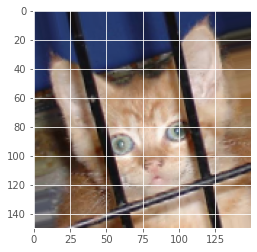

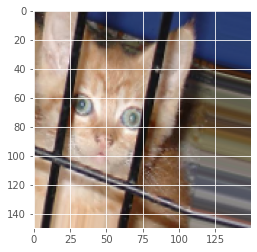

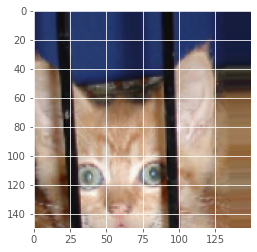

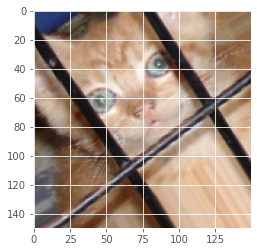

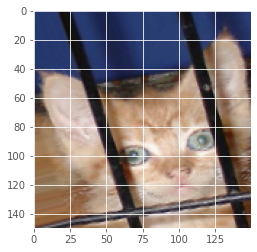

In [31]:
img_path = os.path.join(train_cats_dir, train_cat_fnames[2])
img = load_img(img_path, target_size=(150, 150))
x = img_to_array(img)
x = x.reshape((1, ) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i%5 == 0:
        break

#### 학습, 검증 데이터셋의 Data Generator

In [32]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

val_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### 모델 구성 및 컴파일

In [33]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D(2, 2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['acc'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 17, 17, 128)     

#### 모델 학습 및 학습 과정 시각화
- 런타임유형 GPU 사용

In [34]:
history = model.fit(train_generator,
                    steps_per_epoch =100,
                    epochs=30,
                    batch_size=256,
                    validation_data=validation_generator,
                    validation_steps=50,
                    verbose=2)

Epoch 1/30
100/100 - 20s - loss: 0.6922 - acc: 0.5180 - val_loss: 0.7034 - val_acc: 0.5000 - 20s/epoch - 203ms/step
Epoch 2/30
100/100 - 19s - loss: 0.6938 - acc: 0.5155 - val_loss: 0.6878 - val_acc: 0.6260 - 19s/epoch - 190ms/step
Epoch 3/30
100/100 - 18s - loss: 0.6869 - acc: 0.5630 - val_loss: 0.6628 - val_acc: 0.6530 - 18s/epoch - 183ms/step
Epoch 4/30
100/100 - 19s - loss: 0.6657 - acc: 0.6055 - val_loss: 0.6310 - val_acc: 0.6570 - 19s/epoch - 190ms/step
Epoch 5/30
100/100 - 19s - loss: 0.6676 - acc: 0.5905 - val_loss: 0.6346 - val_acc: 0.6220 - 19s/epoch - 187ms/step
Epoch 6/30
100/100 - 19s - loss: 0.6353 - acc: 0.6390 - val_loss: 0.6028 - val_acc: 0.6810 - 19s/epoch - 189ms/step
Epoch 7/30
100/100 - 18s - loss: 0.6290 - acc: 0.6485 - val_loss: 0.5918 - val_acc: 0.6840 - 18s/epoch - 182ms/step
Epoch 8/30
100/100 - 20s - loss: 0.6116 - acc: 0.6670 - val_loss: 0.5526 - val_acc: 0.7090 - 20s/epoch - 200ms/step
Epoch 9/30
100/100 - 20s - loss: 0.5981 - acc: 0.6855 - val_loss: 0.5545

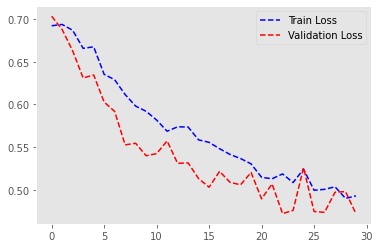

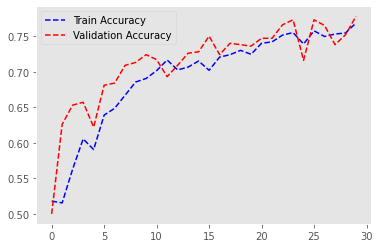

In [37]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure()
plt.plot(epochs, loss, 'b--', label='Train Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs, acc, 'b--', label='Train Accuracy')
plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
plt.grid()
plt.legend()

plt.show()

#### 모델 저장

In [38]:
model.save('cats_and_dogs_model.h5')

### 사전 훈련된 모델 사용

In [39]:
conv_base = VGG16(weights='imagenet', input_shape=(150, 150, 3), include_top=False)

In [40]:
from tensorflow.keras.optimizers import RMSprop

def build_model_with_pretrained(conv_base):
    model = Sequential()
    model.add(conv_base)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', 
                  optimizer=RMSprop(learning_rate=2e-5), 
                  metrics=['accuracy'])
    
    return model

파라미터의 수 확인!

In [41]:
model = build_model_with_pretrained(conv_base)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 256)               2097408   
                                                                 
 dense_13 (Dense)            (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


#### 레이어 동결
- 훈련하기 전, 합성곱 기반 레이어들의 가중치 학습을 막기 위해 이를 동결

In [42]:
print(len(model.trainable_weights))

30


In [43]:
conv_base.trainable = False
print(len(model.trainable_weights))

4


#### 모델 컴파일
- trainable 속성을 변경했기 때문에 다시 모델을 컴파일 해야함

In [44]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=2e-5),
              metrics=['accuracy'])

#### 이미지 제너레이터

In [45]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

val_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### 모델 재학습

In [46]:
history = model.fit(train_generator,
                    steps_per_epoch =100,
                    epochs=30,
                    batch_size=256,
                    validation_data=validation_generator,
                    validation_steps=50,
                    verbose=2)

Epoch 1/30
100/100 - 23s - loss: 0.6358 - accuracy: 0.6480 - val_loss: 0.4783 - val_accuracy: 0.8090 - 23s/epoch - 234ms/step
Epoch 2/30
100/100 - 25s - loss: 0.4970 - accuracy: 0.7780 - val_loss: 0.3874 - val_accuracy: 0.8450 - 25s/epoch - 251ms/step
Epoch 3/30
100/100 - 26s - loss: 0.4323 - accuracy: 0.8050 - val_loss: 0.3456 - val_accuracy: 0.8510 - 26s/epoch - 262ms/step
Epoch 4/30
100/100 - 21s - loss: 0.4151 - accuracy: 0.8220 - val_loss: 0.3286 - val_accuracy: 0.8600 - 21s/epoch - 210ms/step
Epoch 5/30
100/100 - 23s - loss: 0.3856 - accuracy: 0.8355 - val_loss: 0.3166 - val_accuracy: 0.8640 - 23s/epoch - 226ms/step
Epoch 6/30
100/100 - 24s - loss: 0.3683 - accuracy: 0.8430 - val_loss: 0.2947 - val_accuracy: 0.8720 - 24s/epoch - 241ms/step
Epoch 7/30
100/100 - 25s - loss: 0.3652 - accuracy: 0.8465 - val_loss: 0.2896 - val_accuracy: 0.8750 - 25s/epoch - 249ms/step
Epoch 8/30
100/100 - 21s - loss: 0.3528 - accuracy: 0.8485 - val_loss: 0.2893 - val_accuracy: 0.8780 - 21s/epoch - 206

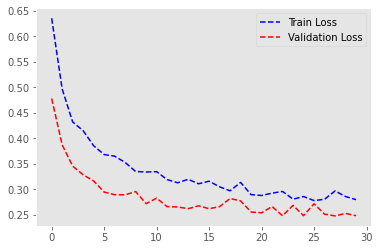

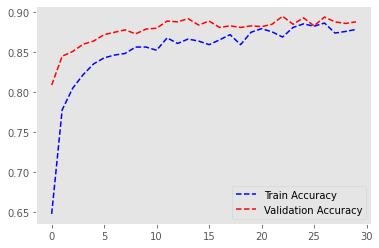

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure()
plt.plot(epochs, loss, 'b--', label='Train Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs, acc, 'b--', label='Train Accuracy')
plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
plt.grid()
plt.legend()

plt.show()

#### 모델 저장

In [51]:
model.save('cats_and_dogs_with_pretrained_model.h5')

## Feature Map 시각화

In [56]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

### 모델 구성

In [53]:
model= load_model('/content/cats_and_dogs_model.h5')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 17, 17, 128)     

In [58]:
img_path = '/content/cats_and_dogs_filtered/validation/dogs/dog.2000.jpg'

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = img_tensor[np.newaxis, ...]
img_tensor /= 255.
print(img_tensor.shape)

(1, 150, 150, 3)


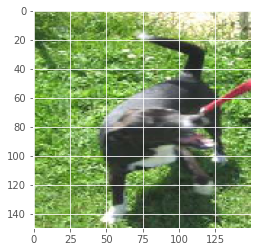

In [59]:
plt.imshow(img_tensor[0])
plt.show()

In [60]:
conv_output = [layer.output for layer in model.layers[:8]]
conv_output

[<KerasTensor: shape=(None, 148, 148, 32) dtype=float32 (created by layer 'conv2d_20')>,
 <KerasTensor: shape=(None, 74, 74, 32) dtype=float32 (created by layer 'max_pooling2d_12')>,
 <KerasTensor: shape=(None, 72, 72, 64) dtype=float32 (created by layer 'conv2d_21')>,
 <KerasTensor: shape=(None, 36, 36, 64) dtype=float32 (created by layer 'max_pooling2d_13')>,
 <KerasTensor: shape=(None, 34, 34, 128) dtype=float32 (created by layer 'conv2d_22')>,
 <KerasTensor: shape=(None, 17, 17, 128) dtype=float32 (created by layer 'max_pooling2d_14')>,
 <KerasTensor: shape=(None, 15, 15, 128) dtype=float32 (created by layer 'conv2d_23')>,
 <KerasTensor: shape=(None, 7, 7, 128) dtype=float32 (created by layer 'max_pooling2d_15')>]

In [61]:
activation_model = Model(inputs=[model.input], outputs=conv_output)

In [62]:
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 0s 223ms/step


In [63]:
len(activations)

8

### 시각화

(1, 148, 148, 32)


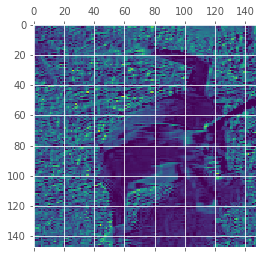

In [64]:
print(activations[0].shape)
plt.matshow(activations[0][0, :, :, 7], cmap='viridis')
plt.show()

(1, 148, 148, 32)


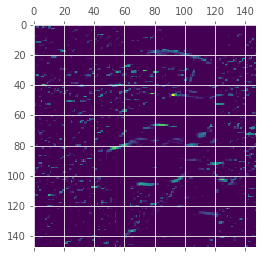

In [65]:
print(activations[0].shape)
plt.matshow(activations[0][0, :, :, 20], cmap='viridis')
plt.show()

(1, 148, 148, 32)


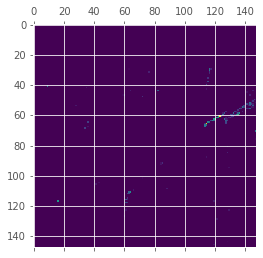

In [66]:
print(activations[0].shape)
plt.matshow(activations[0][0, :, :, 10], cmap='viridis')
plt.show()

### 중간의 모든 활성화에 대해 시각화

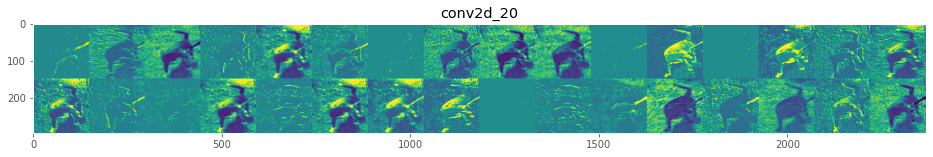

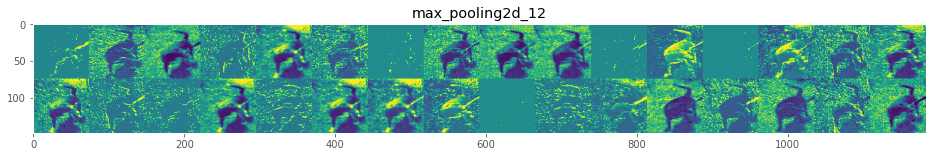

<ipython-input-69-0f749a1d8d8c>:19: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


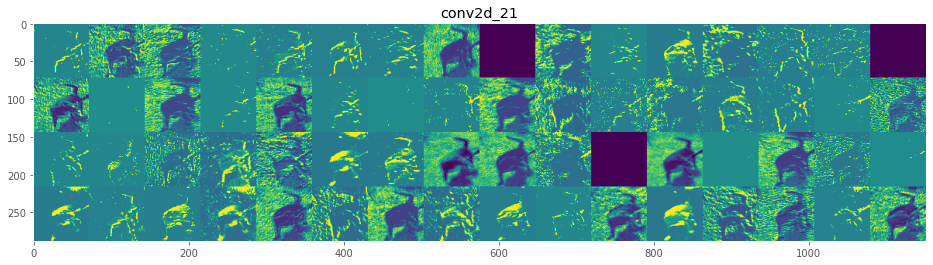

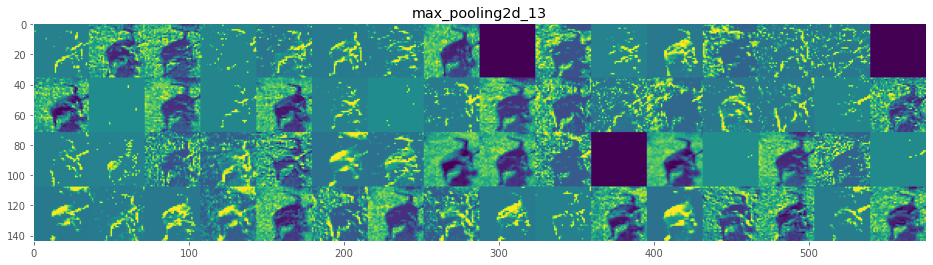

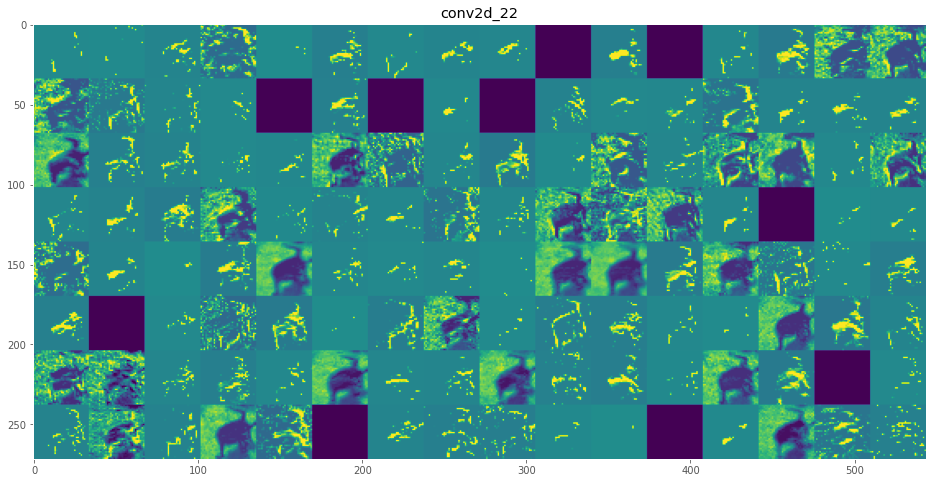

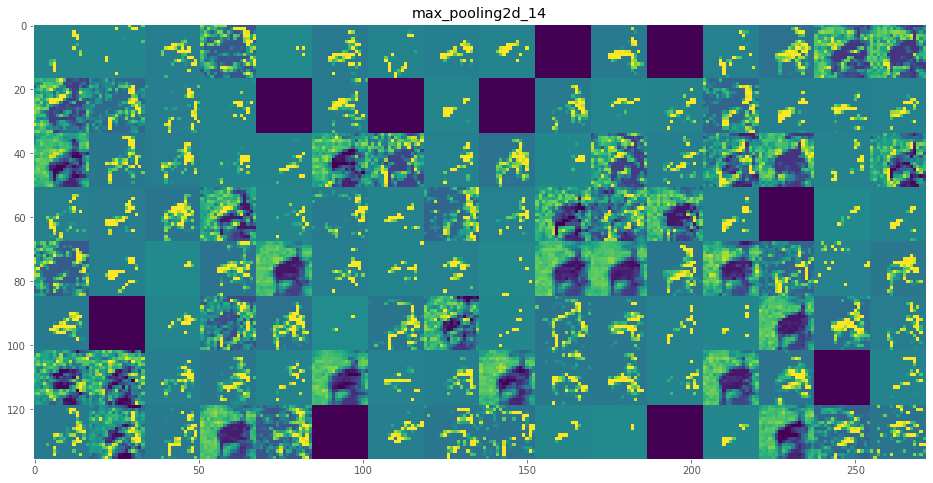

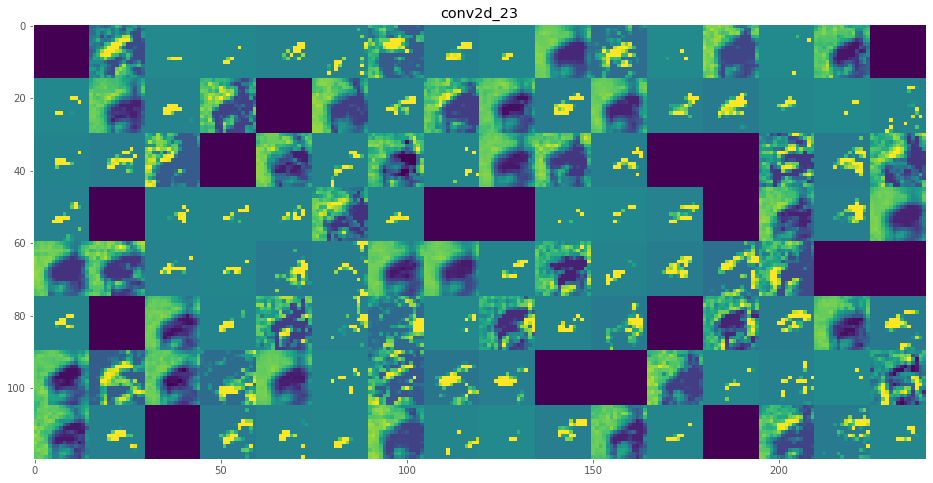

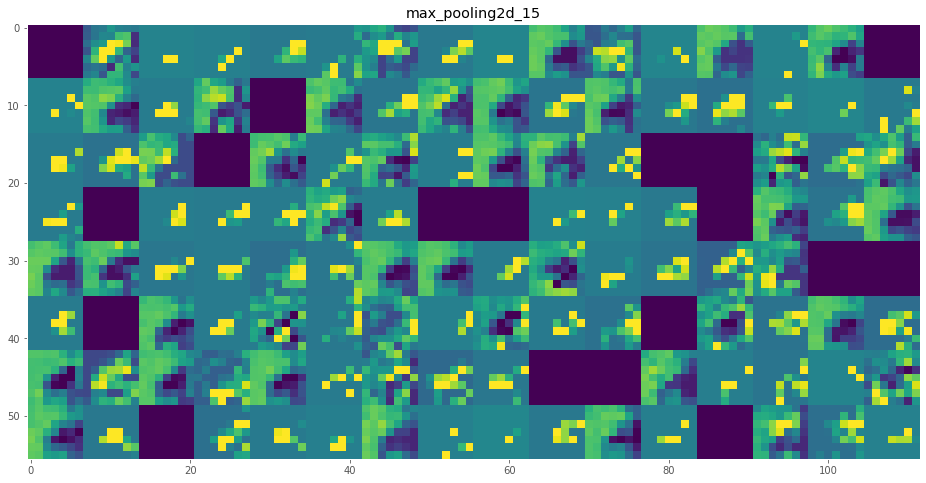

In [69]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    num_features = layer_activation.shape[-1]
    
    size = layer_activation.shape[1]
    
    num_cols = num_features // images_per_row
    display_grid = np.zeros((size * num_cols, images_per_row * size))
    
    for col in range(num_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, : , :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size: (col+1) * size, row * size : (row+1) * size] = channel_image
    
    scale = 1. / size
    
    plt.figure(figsize=(scale * display_grid. shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect= 'auto', cmap='viridis')
    plt.show()